In [3]:
from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import numpy as np
import math
from datetime import datetime,timezone

from scipy import stats


In [4]:
# import functions_framework
# @functions_framework.http
# def load_v2_new_incident_ml_to_bq(request):

isTrainData=True
isExploreMode=True

schema_for_new_data=None
threshold_x_sd = 3  # 2x-4x
split_test=0.2
isShuffle=True  # if false ,it is not stratified

In [5]:
dt_imported=datetime.now(timezone.utc)

str_imported=dt_imported.strftime('%Y-%m-%d %H:%M:%S')
print(f"Imported DateTime: {str_imported}" )

# explore min and max import data
imported_to='2024-01-01' # beginning to 15Nov23
# SELECT max(imported_at) as max_date,min(imported_at) as min_date  FROM `pongthorn.SMartDW.incident` ;
# SELECT max(open_datetime) as max_date,min(open_datetime) as min_date  FROM `pongthorn.SMartDW.incident` ;


Imported DateTime: 2023-12-09 09:24:19


In [6]:
# projectId='smart-data-ml'
# credentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')
# client = bigquery.Client(credentials=credentials, project=projectId)


projectId='pongthorn'
client = bigquery.Client(project=projectId)

dw_dataset_id="SMartDW"
dataset_id="SMartML"

dw_table_id = f"{projectId}.{dw_dataset_id}.incident"

In [7]:
def load_data_bq(sql:str):

 query_result=client.query(sql)
 df_all=query_result.to_dataframe()
 return df_all

def loadDataFrameToBQ(table_id,dfx):
    try:
        if isTrainData:
            job_config = bigquery.LoadJobConfig(
                write_disposition="WRITE_TRUNCATE",
            )
        else:
                   job_config = bigquery.LoadJobConfig(
                write_disposition="WRITE_APPEND",schema=schema_for_new_data
            )

        job = client.load_table_from_dataframe(
            dfx, table_id, job_config=job_config
        )
        job.result()  # Wait for the job to complete.
        print(f"TrainData={isTrainData} : {len(dfx)} rows imported to {table_id} successfully")

    except BadRequest as e:
        print("Bigquery Error\n")
        for e in job.errors:
            print('ERROR: {}'.format(e['message']))

In [8]:
label='severity_id'
labelName='severity_name'

removeCols=['updated_at','imported_at']

# dateCols=['open_datetime','close_datetime','response_datetime','resolved_datetime']
# numbericCols=['open_to_close_hour','response_to_resolved_hour']
# start_end_list=[ ['open_datetime','close_datetime'],['response_datetime','resolved_datetime']]

dateCols=['open_datetime','close_datetime']
numbericCols=['open_to_close_hour']
start_end_list=[ ['open_datetime','close_datetime']]


rangeCols=[]
cateCols=['sla','product_type','brand','service_type','incident_type']

# Create New Data Table

In [9]:
def get_table_schema(table_ml_id):
    schema=[]
    try:
        table=client.get_table(table_ml_id)  # Make an API request.
        schema=table.schema
        print("Table {} already exists.".format(table_ml_id))
    except Exception as ex:
        schema = [
        bigquery.SchemaField("id", "INTEGER", mode="REQUIRED"),
        bigquery.SchemaField("severity_id", "INTEGER", mode="REQUIRED"),
        bigquery.SchemaField("severity_name", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("sla", "STRING", mode="REQUIRED"),    
        bigquery.SchemaField("product_type", "STRING", mode="REQUIRED"),  
        bigquery.SchemaField("brand", "STRING", mode="REQUIRED"),  
        bigquery.SchemaField("service_type", "STRING", mode="REQUIRED"),  
        bigquery.SchemaField("incident_type", "STRING", mode="REQUIRED"),  
        bigquery.SchemaField("open_to_close_hour", "FLOAT", mode="REQUIRED"),
        bigquery.SchemaField("range_open_to_close_hour", "STRING", mode="REQUIRED"),    
        bigquery.SchemaField("imported_at", "DATETIME", mode="REQUIRED")    
        ]

        table = bigquery.Table(table_ml_id,schema=schema)
        table.time_partitioning = bigquery.TimePartitioning(
        type_=bigquery.TimePartitioningType.DAY,field="imported_at")


        table = client.create_table(table)  # Make an API request.
        print(
            "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
        )
    finally:
       print(f"Get Schema of {table_ml_id} as below.")    
       return schema
        

# Get Max Import Data From New Data

In [10]:
def get_last_imported_at(table_ml_id):

    sql_lastImport=f"SELECT max(imported_at) as last_imported from `{table_ml_id}` "

    print(sql_lastImport)

    job_lastImported=client.query(sql_lastImport)
    str_lastImported=None
    for row in job_lastImported:    
        if row.last_imported is not None: 
            str_lastImported=row.last_imported.strftime('%Y-%m-%d %H:%M:%S')
    print(f"Last Imported DateTime: {str_lastImported}" )

    if str_lastImported is not None:
      print("Start date from last loading")  
      start_date_query=str_lastImported
    else:
      start_date_query=imported_to  
      print("Init First loading") 
    return start_date_query    
    

# Explore and Transform Data

In [11]:
order_by=" order by id"
#order_by="order by imported_at

sql_all=f"""
SELECT  id,severity_id,severity_name
,sla,product_type,brand,service_type,incident_type
,open_datetime,  close_datetime
,updated_at,imported_at
FROM `{dw_table_id}` """

if isTrainData: # get from imported_to specified by you
    print(f"Build train/test data during imported date < {datetime.strptime(imported_to,'%Y-%m-%d')}")

    train_name='train2_incident'
    test_name='test2_incident'
    train_table_id=f"{projectId}.{dataset_id}.{train_name}"
    test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
    print(f"TrainTable2={train_table_id} and TestTable2={test_tabel_id}")
    
    sql_all=f""" {sql_all}
    WHERE imported_at< '{imported_to}'
    {order_by}
    
    """
    
else: # get from max update
    new_incident_name='new2_incident'    
    new_incident_table_id=f"{projectId}.{dataset_id}.{new_incident_name}"
    print(f"{new_incident_table_id}")
    
    # 1.get table and its schema
    schema_for_new_data=get_table_schema(new_incident_table_id)
    # print(schema_for_new_data)
    imported_to=get_last_imported_at(new_incident_table_id)  # get  start_date_query  from this method
    print(f"Load the most up-to-date new data from imported date >= {imported_to}")
    print(imported_to)
    
    
    sql_all=f""" {sql_all}
    WHERE imported_at>= '{imported_to}'
    {order_by}
    
    """

print(sql_all)


Build train/test data during imported date < 2024-01-01 00:00:00
TrainTable2=pongthorn.SMartML.train2_incident and TestTable2=pongthorn.SMartML.test2_incident
 
SELECT  id,severity_id,severity_name
,sla,product_type,brand,service_type,incident_type
,open_datetime,  close_datetime
,updated_at,imported_at
FROM `pongthorn.SMartDW.incident` 
    WHERE imported_at< '2024-01-01'
     order by id
    
    


In [12]:
print("Load data from Bigquery")
df_all=load_data_bq(sql_all)
print(f"Total origianal rows prior to perform data prep: {len(df_all)}")
no_original_rows=len(df_all)

if no_original_rows==0:
 print("No records from bigquery")  
 quit()
 # return "No new data imported to bigquery"   
else:
    
 df_all=df_all.drop_duplicates(subset=['id'],keep='last')   
 print(f"Import at :{df_all['imported_at'].min()} - {df_all['imported_at'].max()}")
 print(f"Open Date : {df_all['open_datetime'].min()} - {df_all['open_datetime'].max()}")   

print(df_all.info())
df_all[['id',"severity_id","severity_name","updated_at","imported_at"]].tail()

Load data from Bigquery
Total origianal rows prior to perform data prep: 3966
Import at :2023-12-09 09:09:29.628598 - 2023-12-09 09:09:29.628598
Open Date : 2019-11-01 08:30:00 - 2023-12-30 16:47:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3966 entries, 0 to 3965
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              3966 non-null   Int64         
 1   severity_id     3966 non-null   Int64         
 2   severity_name   3966 non-null   object        
 3   sla             3966 non-null   object        
 4   product_type    3966 non-null   object        
 5   brand           3966 non-null   object        
 6   service_type    3966 non-null   object        
 7   incident_type   3966 non-null   object        
 8   open_datetime   3966 non-null   datetime64[ns]
 9   close_datetime  3966 non-null   datetime64[ns]
 10  updated_at      3966 non-null   datetime64[ns]
 11  imported_at  

,id,severity_id,severity_name,updated_at,imported_at
3961,4163,2,Major,2023-12-08 11:21:44,2023-12-09 09:09:29.628598
3962,4164,4,Cosmetic,2023-12-07 13:19:38,2023-12-09 09:09:29.628598
3963,4167,2,Major,2023-12-07 20:58:54,2023-12-09 09:09:29.628598
3964,4168,3,Minor,2023-12-08 01:55:04,2023-12-09 09:09:29.628598
3965,4169,2,Major,2023-12-08 15:47:56,2023-12-09 09:09:29.628598


# Transform and enrich data

# Manage Numberic Cols
### 1-Find Time Inverval
### 2-Remove outlier on Time Interval to service
### 3-Find any rows  contain zero time period
### 4-Create range from time-interval (best,good,moderate,bad,worst)

# Bining Range

function is used to separate the array elements into many different ranges . 
The cut function is mainly used to perform statistical analysis on scalar data. 

we can convert hour to range   
* (0, 24] =by 1 day =best
* (24, 168] =  1day -1 week  =good
* (168, 360]=  1week- 15 days(half a month) =fair
* (360, 720]= 15 dasy-1 month =bad
* (720, 2349]=1 month-1 Q =worst

open_to_close_hour ,response_to_resolved_hour , Mostly  we can complate by 1 day (0, 24]
there are few cases that take long to close incident (360, 720]   15 day to  1month

In [13]:
print("Manage Numberic Cols")
listDiffDateDeltaCols=[]
listDiffHourCols=[]
for item  in  start_end_list:
   diff_str=f"{item[0]}_to_{item[1]}" 
   diff_str=diff_str.replace('_datetime','')  
   listDiffDateDeltaCols.append(diff_str)
   df_all[diff_str]=df_all[item[1]]-df_all[item[0]]
    
   diff_hour=f'{diff_str}_hour'
   listDiffHourCols.append(diff_hour)
   df_all[diff_hour] = df_all[diff_str].apply(lambda x:  x.total_seconds() / (60*60) if x is not np.nan else np.nan  )


# https://www.geeksforgeeks.org/z-score-for-outlier-detection-python/
xScoreDiffHourCols=[]
for col in listDiffHourCols:
  z_col=f"zscore_{col}"   
  df_all[z_col] = np.abs(stats.zscore(df_all[col]))   
  xScoreDiffHourCols.append(z_col)  

# df_all.tail()

Manage Numberic Cols


# Remove oulier  and delete zero hour training data

In [14]:
if isTrainData :
    print("Remove oulier  and delete zero hour training data")
    for col in  xScoreDiffHourCols:
      df_all=df_all.query(f"{col}<@threshold_x_sd")


    allRows=df_all.shape[0]
    for col in numbericCols:
        zeroRows=len(df_all.query(f"{col}==0"))
        pctZeroHour=round(zeroRows/allRows*100,1)
        print(f"No. 0-hour row on {col} = {zeroRows}({pctZeroHour} %)")
        df_all=df_all.query(f'{col}!=0')

Remove oulier  and delete zero hour training data
No. 0-hour row on open_to_close_hour = 2(0.1 %)


# Apply Service Level

In [15]:
def service_hour_range(x_hour):
    if x_hour>0 and x_hour<=24:
      return "soonest"
    elif x_hour>25 and x_hour<=168:
      return "soon"
    elif x_hour>168 and x_hour<=360:
      return "fair"
    elif x_hour>360 and x_hour<=720:
      return "late"
    else:
      return "latest"

for col in numbericCols:
    range_col=f"range_{col}"
    rangeCols.append(range_col)
    df_all[range_col]=df_all[col].apply(service_hour_range)

# Final TRansform

In [16]:
removeCols=removeCols+dateCols+xScoreDiffHourCols+listDiffDateDeltaCols
print(f"Remove {removeCols}")
df_all=df_all.drop(columns=removeCols)
no_rows_after_removing_outlier=len(df_all)
pct_row_decrease=round( (no_original_rows-no_rows_after_removing_outlier)/no_original_rows*100 ,0)

print(f"% remove data {pct_row_decrease}")

df_all[['id','severity_id']] =df_all[['id','severity_id']].astype('int64')

if isTrainData==False:
    df_all['imported_at']=dt_imported

print(df_all.info())


print(f"pct removed data ={(no_original_rows-len(df_all))/no_original_rows*100}")
#it is pretty close to 5%   , at most 10% is removable
# df_all[listDiffHourCols].describe(percentiles=[.95,.75,.50,.25,.05]).drop(index=['count','std'])

df_all.tail(30)

Remove ['updated_at', 'imported_at', 'open_datetime', 'close_datetime', 'zscore_open_to_close_hour', 'open_to_close']
% remove data 1.0
<class 'pandas.core.frame.DataFrame'>
Index: 3913 entries, 0 to 3965
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        3913 non-null   int64  
 1   severity_id               3913 non-null   int64  
 2   severity_name             3913 non-null   object 
 3   sla                       3913 non-null   object 
 4   product_type              3913 non-null   object 
 5   brand                     3913 non-null   object 
 6   service_type              3913 non-null   object 
 7   incident_type             3913 non-null   object 
 8   open_to_close_hour        3913 non-null   float64
 9   range_open_to_close_hour  3913 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 336.3+ KB
None
pct removed data =1.3363590519415

,id,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,range_open_to_close_hour
3936,4128,2,Major,24x7 4Hrs Resolution Time,Firewall,Palo Alto,Incident,General Incident,0.400000,soonest
3937,4129,2,Major,24x7 4Hrs Resolution Time,Firewall,Palo Alto,Incident,General Incident,0.666667,soonest
3938,4130,2,Major,24x7 4Hrs Resolution Time,Software,VMWare,Incident,Software,1.183333,soonest
3939,4131,2,Major,24x7 4Hrs Resolution Time,Software,VMWare,Incident,Software,1.166667,soonest
3940,4132,4,Cosmetic,8x5 4Hrs Response Time,Access Point,HPE,Request,General Incident,27.000000,soon
3941,4133,2,Major,8x5 4Hrs Response Time,Access Point,HPE,Incident,Network Adapter Failure,190.733333,fair
3942,4134,4,Cosmetic,8x5 4Hrs Response Time,Access Point,HPE,Incident,General Incident,32.000000,soon
3943,4135,2,Major,24x7 4Hrs Response Time,Software,Red Hat,Incident,Software,1.783333,soonest
3944,4136,2,Major,24x7 4Hrs Response Time,Storage,Veritas,Incident,Backup Failure,7.733333,soonest
3945,4137,2,Major,24x7 4Hrs Response Time,Server,HPE,Incident,Hard Disk Drive Failure,5.216667,soonest


In [17]:
# # https://www.geeksforgeeks.org/pandas-cut-method-in-python/
# def explore_ranges_numberic_val(col,rangeList):
#     print(col)
#     rangeList.sort()
#     return pd.cut(df_all[col],rangeList, right=True).value_counts()
# range1= [0,24, 168, 360, 720,math.floor(df_all['open_to_close_hour'].max())]
# print(explore_ranges_numberic_val('open_to_close_hour',range1))
# print("=======================================================")

# range2= [0,24, 168, 360, 720,math.floor(df_all['response_to_resolved_hour'].max())]
# print(explore_ranges_numberic_val('response_to_resolved_hour',range2))
# print("=======================================================")



# Plot Numeric  and Category columns

Plot Numeric  and Category columns


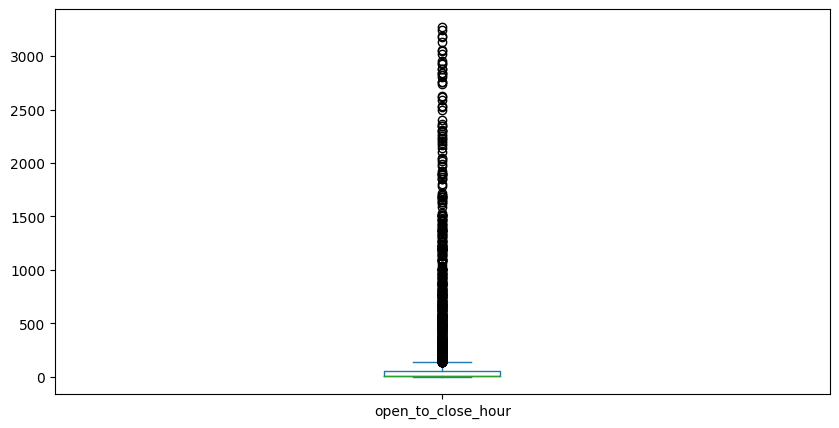

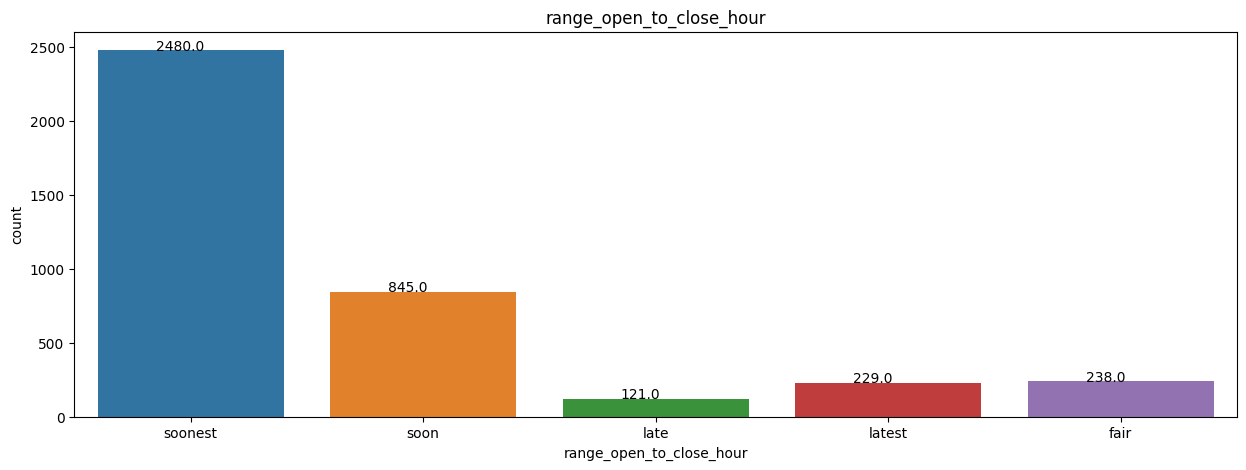

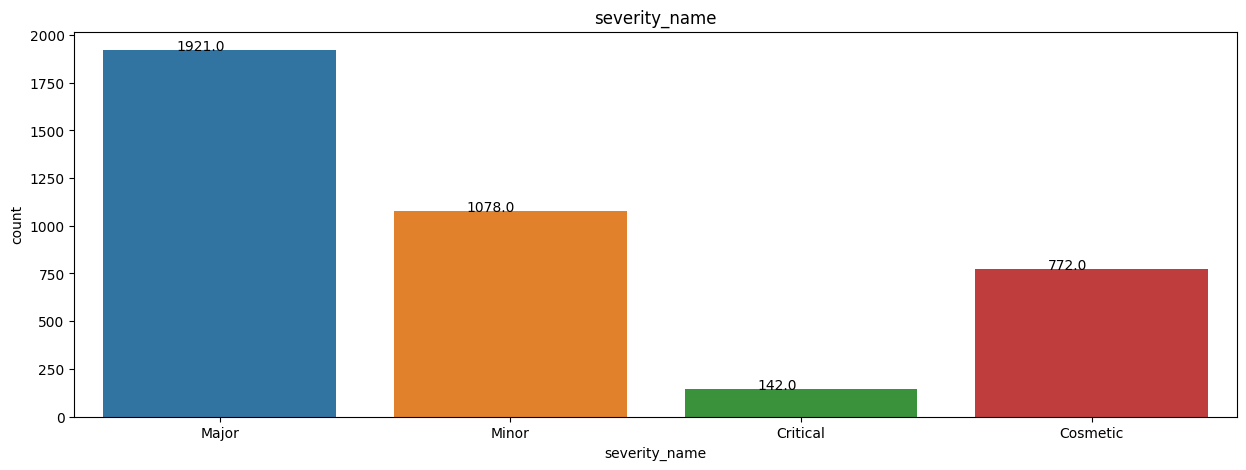

In [18]:
# comment on google cloud
if isExploreMode:
    print("Plot Numeric  and Category columns")
    import seaborn as sns
    import matplotlib.pyplot  as plt

if isExploreMode:
    df_all[numbericCols].plot(kind='box',subplots=True,layout=(1,len(numbericCols)),sharex=False, sharey=False,figsize=(10,5))
    plt.show()
    
if isExploreMode:
    barCols=rangeCols+["severity_name"]
    for col in barCols:
        fig , ax = plt.subplots(figsize=(15,5))
        ax =sns.countplot(x=col, data=df_all,)
        for p in ax.patches:
           ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
        plt.title(col)
        plt.show()

# Build Label and Split into Train/Test DataSet

In [19]:
if isTrainData:
    
    print(" Build Label and Split into Train/Test DataSet")
    from sklearn.model_selection import train_test_split
    
    # create label
    map_severity_to_class={4:0,3: 1, 2: 2, 1: 3}
    print(f"Map severity id to LabelCode: {str(map_severity_to_class)}")

    df_all['label_multi_severity'] =df_all['severity_id'].map(map_severity_to_class) 
    def map_4to2_serverity(severity_id):
        if severity_id==1 or severity_id==2:
           return 1
        else:
           return 0 
    df_all['label_binary_severity'] =df_all['severity_id'].apply(map_4to2_serverity)

    print( list(df_all['label_multi_severity'].unique()))
    print(df_all['label_binary_severity'].unique())

    #Split data into 2 dataset to BQ
    len_all=len(df_all)
    print(f"All Data = {len_all}")
    
# shufflebool, default=True
# Whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.
# stratifyarray-like, default=None
# If not None, data is split in a stratified fashion, using this as the class labels. Read more in the User Guide.

# Split the 80% of total as train
# The remaining  will be splited equally 50% for valuation and the rest of later part is test
    train, test = train_test_split(df_all,test_size=split_test,random_state=1000,shuffle=isShuffle) 

    len_all=len(df_all)
    len_train=len(train)

    len_test=len(test)
    print(f'{len_train} =train examples ({round(len_train/len_all*100,1)}%)')
    print(f'{len_test} =test examples ({round(len_test/len_all*100,1)}%)')

    print(train.tail())

    loadDataFrameToBQ(train_table_id,train)
    loadDataFrameToBQ(test_tabel_id,test)  
    
    # if isExploreMode:
    #     train.to_csv(f"data/{train_name}.csv",index=False)
    #     test.to_csv(f"data/{test_name}.csv",index=False)
        
else:
    print(" Build Unseen DataSet")
    
    loadDataFrameToBQ(new_incident_table_id,df_all)
    

 Build Label and Split into Train/Test DataSet
Map severity id to LabelCode: {4: 0, 3: 1, 2: 2, 1: 3}
[2, 1, 3, 0]
[1 0]
All Data = 3913
3130 =train examples (80.0%)
783 =test examples (20.0%)
        id  severity_id severity_name                        sla product_type  \
3374  3515            3         Minor  24x7 4Hrs Resolution Time     Software   
3828  4002            2         Major    24x7 4Hrs Response Time      Storage   
2159  2261            2         Major  24x7 6Hrs Resolution Time      Storage   
621    664            2         Major    24x7 4Hrs Response Time      Storage   
1490  1564            4      Cosmetic    24x7 4Hrs Response Time     Software   

       brand service_type            incident_type  open_to_close_hour  \
3374     HPE      Request                 Software          407.000000   
3828  NetApp     Incident         General Incident           26.650000   
2159     HPE     Incident     Power Supply Failure           25.516667   
621   NetApp     Inciden

In [122]:
# return "Imported data to bigquery successfully"